In [1]:
import scipy.io as sio
from torch.utils.data import DataLoader 
import torch
from torch import nn
import numpy as np
from torchsummary import summary
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
filename1 = '/content/drive/MyDrive/denoiser/deconvolver_sin1.mat'
#filename2 = '/content/drive/MyDrive/denoiser/data_randomvariance.mat'
batch_size = 64

data1 = sio.loadmat(filename1)
#data2 = sio.loadmat(filename2)

train1 = data1['train']
test1 = data1['test']

#train2 = data2['train']
#test2 = data2['test']

#train = np.concatenate((train1[0:20000,:,:],train2[0:20000,:,:]))
#test = np.concatenate((test1[0:3000,:,:],test2[0:3000,:,:]))

train_data = DataLoader(train1,batch_size=batch_size,shuffle=True,num_workers=2)
test_data = DataLoader(test1,batch_size=batch_size,shuffle=True,num_workers=2)

In [4]:
class denoiser(nn.Module):
  def __init__(self):
    super(denoiser,self).__init__()

    self.C0 = nn.Conv1d(1,2,kernel_size=17,padding=8,bias=False)

    # self.C1 = nn.Conv1d(1,2,kernel_size=17,padding=8,bias=False)
    # self.C1 = nn.Conv1d(1,1,kernel_size=17,padding=8,bias=False)
    self.C1 = nn.Conv1d(2,1,kernel_size=17,padding=8,bias=False)


    self.C2 = nn.Conv1d(2,1,kernel_size=17,padding=8,bias=False)
    # self.C2 = nn.Conv1d(2,2,kernel_size=17,padding=8,bias=False)
    self.C3 = nn.Conv1d(2,2,kernel_size=37,padding=18,bias=False)
    self.C4 = nn.Conv1d(2,1,kernel_size=9,padding=4,bias=False)


  def forward(self,x):

    # xp_1 = F.relu(x)
    # xn_1 = F.relu(-x)
    x_1 = F.relu(self.C0(x))

    # xp_2 = self.C1(xp_1)                                  # C1 is 1 input and 2 output
    # xn_2 = F.conv1d(xn_1,-self.C1.weight,padding=8)
    # x_2  = F.relu(xp_2 + xn_2)


    xp_2 = F.relu(self.C1(x_1))                         
    xn_2 = F.relu(F.conv1d(x_1,torch.flip(self.C1.weight,[1,2]),padding=8))
    # xn_2 = F.relu(F.conv1d(x_1,torch.flip(self.C1.weight,[1]),padding=8))
    x_2 = torch.cat((xp_2,xn_2),axis=1)
    # xp_2_1 = self.C1(xp_1)                                # C1 is 1 input and 1 output
    # xp_2_2 = F.conv1d(xn_1,-self.C1.weight,padding=8)
    # xn_2_1 = F.conv1d(xp_1,-self.C1.weight,padding=8)
    # xn_2_2 = F.conv1d(xn_1,self.C1.weight,padding=8)
    # xp_2 = F.relu(xp_2_1 + xp_2_2)
    # xn_2 = F.relu(xn_2_1 + xn_2_2)
    # x_2  = torch.cat((xp_2,xn_2),axis=1)

    # x_2 = F.relu(self.C1(x_1))                              # C1 is 2 input and 2 output

    xp_3 = F.relu(self.C2(x_2))                           # C2 is 2 input and 1 output
    xn_3 = F.relu(F.conv1d(x_2,torch.flip(self.C2.weight,[1,2]),padding=8))
    # xn_3 = F.relu(F.conv1d(x_2,torch.flip(self.C2.weight,[1]),padding=8))
    x_3 = torch.cat((xp_3,xn_3),axis=1)

    # x_3 = F.relu(self.C2(x_2))                              # C2 is 2 input and 2 output

    x = F.relu(self.C3(x_3))
    x = self.C4(x)

    # xp_2 = F.relu(self.C1(xp_1))
    # xn_2 = F.relu(self.C1(xn_1))
    # xp_3 = F.relu(self.C2(xp_2))
    # xn_3 = F.relu(self.C2(xn_2))
    # x = torch.cat((xp_3,xn_3),axis=1)
    # x = F.relu(self.C3(x))
    # x = self.C4(x)
    return x

In [5]:
model = denoiser()
# weight = sio.loadmat('/content/drive/MyDrive/denoiser/deconvspe_pre.mat')
weight = sio.loadmat('/content/drive/MyDrive/denoiser/sin23_2.mat')
model._modules['C0']._parameters['weight'].data = torch.from_numpy(weight['conv1'])
# model._modules['C1']._parameters['weight'].data = torch.from_numpy(weight['conv2'])
# model._modules['C2']._parameters['weight'].data = torch.from_numpy(weight['conv3'])
model._modules['C3']._parameters['weight'].data = torch.from_numpy(weight['conv4'])
model._modules['C4']._parameters['weight'].data = torch.from_numpy(weight['conv5'])
# model._modules['conv'][6]._parameters['weight'].data = torch.from_numpy(weight['conv5'])

# model._modules['C0']._parameters['weight'].data = torch.rand(2,1,17)
# model._modules['C1']._parameters['weight'].data = torch.rand(1,2,17)
# model._modules['C2']._parameters['weight'].data = torch.rand(1,2,17)

In [6]:
for name,value in model.named_parameters():
  # if (name=='C3.weight')|(name=='C4.weight'):
  if (name=='C0.weight')|(name=='C3.weight')|(name=='C4.weight'):
    value.requires_grad = False

epochs = 500
device = torch.device("cuda:0")
model = model.to(device)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()),lr=1e-3)
#optimizer = torch.optim.SGD(model.parameters(),lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=300,gamma=0.1)
loss = nn.MSELoss().to(device)
summary(model, (1, 500))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1               [-1, 2, 500]              34
            Conv1d-2               [-1, 1, 500]              34
            Conv1d-3               [-1, 1, 500]              34
            Conv1d-4               [-1, 2, 500]             148
            Conv1d-5               [-1, 1, 500]              18
Total params: 268
Trainable params: 68
Non-trainable params: 200
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.03
Params size (MB): 0.00
Estimated Total Size (MB): 0.03
----------------------------------------------------------------


Epoch: 0      train loss: 1.654530      test loss: 0.798388
Epoch: 5      train loss: 0.575519      test loss: 0.566999
Epoch: 10      train loss: 0.533799      test loss: 0.536878
Epoch: 15      train loss: 0.521370      test loss: 0.524656
Epoch: 20      train loss: 0.519212      test loss: 0.523671
Epoch: 25      train loss: 0.518702      test loss: 0.522334
Epoch: 30      train loss: 0.517845      test loss: 0.522042
Epoch: 35      train loss: 0.517542      test loss: 0.521542
Epoch: 40      train loss: 0.517332      test loss: 0.521291
Epoch: 45      train loss: 0.517109      test loss: 0.521068
Epoch: 50      train loss: 0.517117      test loss: 0.520587
Epoch: 55      train loss: 0.517027      test loss: 0.520865
Epoch: 60      train loss: 0.517095      test loss: 0.520930
Epoch: 65      train loss: 0.517060      test loss: 0.520712
Epoch: 70      train loss: 0.516938      test loss: 0.520685
Epoch: 75      train loss: 0.516800      test loss: 0.520631
Epoch: 80      train loss:

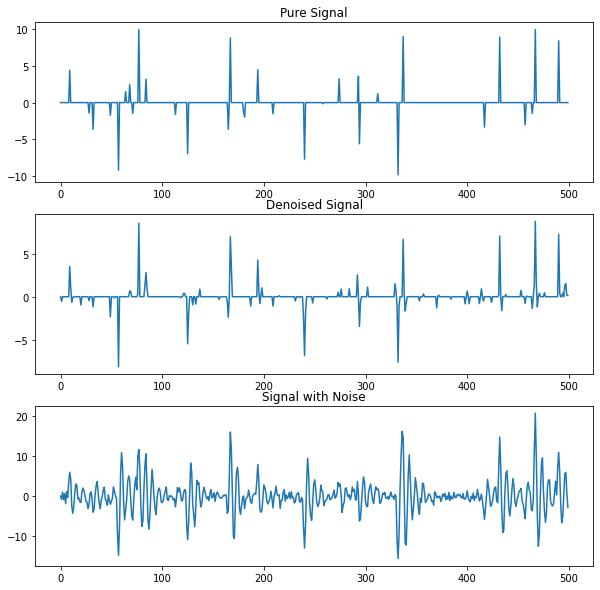

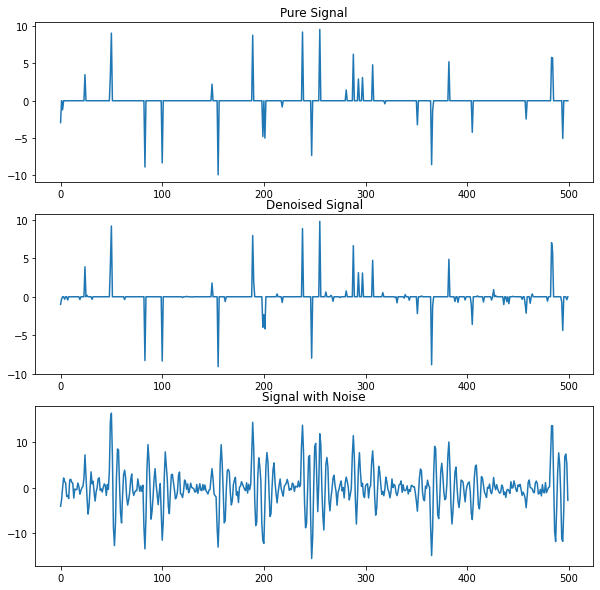

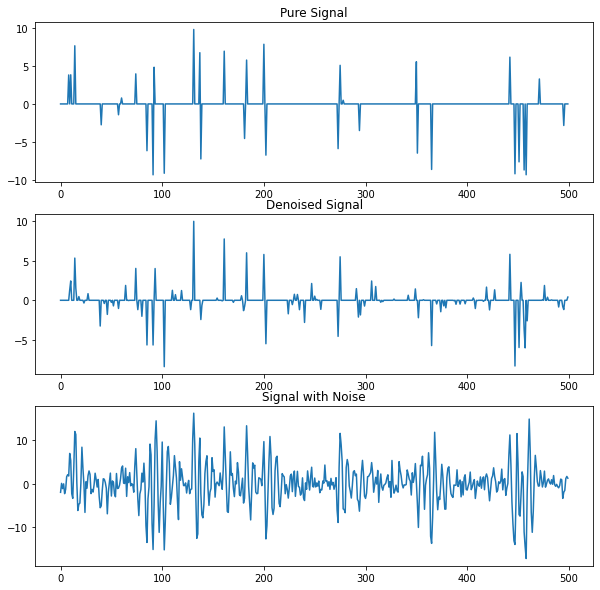

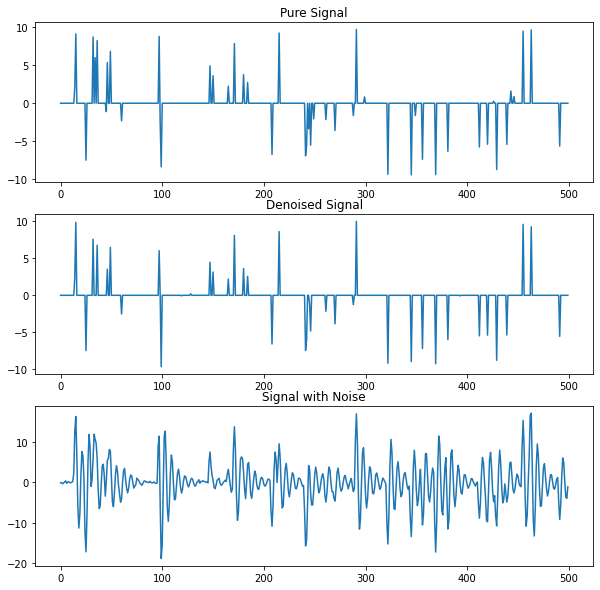

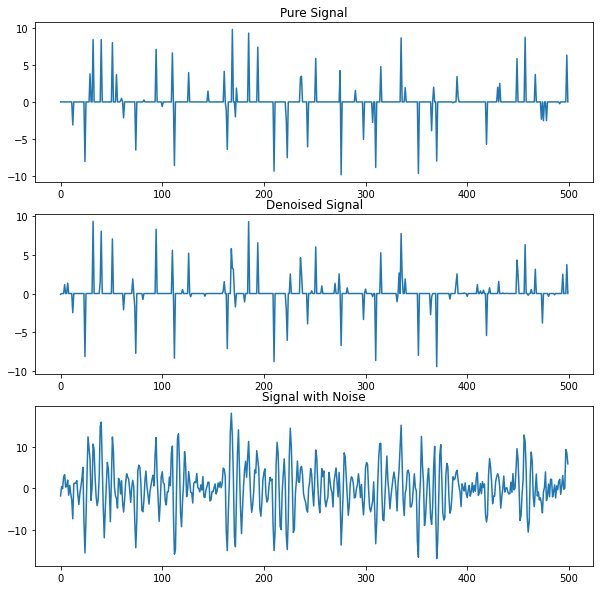

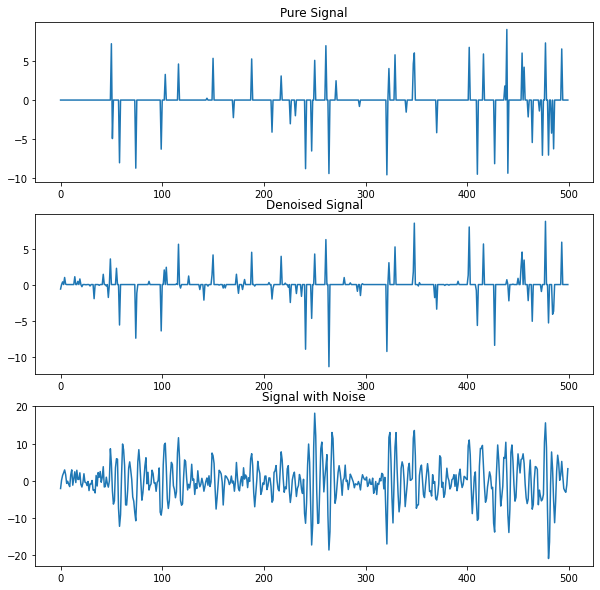

In [7]:
train_loss_epoch = []
test_loss_epoch = []
for epoch in range(epochs):
  train_losses = []
  test_losses = []
  for training in train_data:
    model.train()
    x_train = training[:,0,:].view(-1,1,500).type(torch.FloatTensor).to(device)
    y_train = training[:,2,:].view(-1,1,500).type(torch.FloatTensor).to(device)
    optimizer.zero_grad()
    y_pred = model(x_train)
    loss_train = loss(y_pred,y_train)
    loss_train.backward()
    optimizer.step()
    train_losses.append(loss_train.item())
  train_loss_epoch.append(np.mean(train_losses))
  scheduler.step()

  for testing in test_data:
    model.eval()
    x_test = testing[:,0,:].view(-1,1,500).type(torch.FloatTensor).to(device)
    y_test = testing[:,2,:].view(-1,1,500).type(torch.FloatTensor).to(device)
    y_pred = model(x_test)
    loss_test = loss(y_pred,y_test)
    test_losses.append(loss_test.item())
  test_loss_epoch.append(np.mean(test_losses))

  if (epoch%5)==0:
    print("Epoch: %d      train loss: %f      test loss: %f" %(epoch,np.mean(train_losses),np.mean(test_losses)))

  if ((epoch%100)==99)|(epoch==0):
    signal = y_test.view(-1,500).cpu().detach().numpy()
    denoised = y_pred.view(-1,500).cpu().detach().numpy()
    noisy = x_test.view(-1,500).cpu().detach().numpy()
    #SDR = np.mean(np.sum(signal**2,1)/np.sum(denoised**2,1))
    #print("Epoch: %d      SDR: %f" %(epoch,SDR))
    plt.figure(figsize=(10,10))
    plt.subplot(3,1,1)
    plt.plot(signal[0])
    plt.title('Pure Signal')
    plt.subplot(3,1,2)
    plt.plot(denoised[0])
    plt.title('Denoised Signal')
    plt.subplot(3,1,3)
    plt.plot(noisy[0])
    plt.title('Signal with Noise')


In [8]:
weight_trained = dict()
# weight_trained['conv1'] = model._modules['conv'][0]._parameters['weight'].data.cpu().numpy()
weight_trained['conv1'] = model._modules['C0']._parameters['weight'].data.cpu().numpy()
weight_trained['conv2'] = model._modules['C1']._parameters['weight'].data.cpu().numpy()
weight_trained['conv3'] = model._modules['C2']._parameters['weight'].data.cpu().numpy()
weight_trained['conv4'] = model._modules['C3']._parameters['weight'].data.cpu().numpy()
weight_trained['conv5'] = model._modules['C4']._parameters['weight'].data.cpu().numpy()
sio.savemat('/content/drive/MyDrive/denoiser/deconv122_9.mat', mdict=weight_trained)